In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

from scipy.stats import norm

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance, DMatrix

from tqdm import tqdm
from pickle import dump, load

from scipy import ndimage as nd

In [2]:
import ml_eke
#import tensorflow as tf
#from tensorflow import keras

# Data loading

We need to load the samples. `columns` is a list in which we keep all needed predictands.

In [3]:
columns1 =  [
            #'MKE_z',
            'MKE_sfc',
            'slope_z',
            'relative_vorticity_z',
            'divergence_z',
            'deformation_z',
            'relative_vorticity_sfc',
            'divergence_sfc',
            'deformation_sfc',
            'Rd_dx_z'
            ] 

columns2 = [
            'grad_SSH_sfc',
            #'Rd_dx_sfc'
            ]

columns_2_3 = ['Rd_dx_sfc',
                'grad_SSH_sfc', 
                'relative_vorticity_sfc', 
                'divergence_sfc', 
                'deformation_sfc',
                'slope_z'
                ]

columns_2_3_new = ['MKE_sfc',
                   'slope_z',
                   'Rd_dx_z',
                   'relative_vorticity_sfc',
                 #'divergence_sfc',
                 #'deformation_sfc'
                  ]

columns_1_4 = ['MKE_sfc',
                'slope_z',
                'Rd_dx_z',
                'relative_vorticity_sfc',
               'grad_SSH_sfc']

columns = columns_2_3_new

def get_samples(start, end, columns, model_data, predictands=['EKE_sfc']):

    samples = []
    targets = []
    for sample in tqdm(range(start, end), desc="Extracting samples"):
        X, Y, mask = model_data.extract_sample_from_time(predictors=columns, predictands=predictands, sample_idx=sample)
        samples.append(pd.DataFrame(X.data, columns=columns))
        targets.append(pd.DataFrame(Y.data, columns=["EKE"]))

    data = pd.concat(samples).reset_index()
    data.drop("index", inplace=True, axis=1)
    targets = pd.concat(targets).reset_index()
    targets.drop("index", inplace=True, axis=1)
    data["EKE"] = targets["EKE"]
    
    return data


# Andrew Shao's wisdom
def helmholtz_smooth_transform(array, coeff=1, gauss_smooth=1):
    return nd.gaussian_filter(array + coeff*nd.laplace(array), gauss_smooth)

def regularize_2D(x, skip_col=None):
    
    y = x.copy()
    for i in range(y.shape[-1]):
        if skip_col is not None and skip_col[i]:
            continue 
        else:
            y[:,:,i] = helmholtz_smooth_transform(y[:,:,i], coeff=1)
    
    return y

def get_samples_2D(start, end, columns, model_data, predictands=['EKE_sfc'], preprocess=False, skip_preprocess_var=[]):
    
    # get first sample and infer size
    samples, targets, masks = model_data.extract_sample_from_time_2D(predictors=columns,predictands = predictands, sample_idx = start)
    skip_col = [columns[i] in skip_preprocess_var for i in range(len(columns))]
    
    samples = np.expand_dims(samples, axis=0)
    if preprocess:
        samples[0,:,:,:] = regularize_2D(samples[0,:,:,:], skip_col)
    targets = np.expand_dims(targets, axis=0)
    masks   = np.expand_dims(masks, axis=0)
    
    
    for sample in tqdm(range(start+1, end), desc="Extracting 2D samples"):
        X, Y, mask = model_data.extract_sample_from_time_2D(predictors=columns,predictands = predictands, sample_idx = sample)
        if preprocess:
            samples = np.append(samples, [regularize_2D(X, skip_col)], axis=0)
        else:
            samples = np.append(samples, [X], axis=0)
        targets = np.append(targets, [Y], axis=0)
        masks   = np.append(masks,   [mask], axis=0)
        
    return samples, targets, masks

In [4]:
def maps_to_array(X, Y):
    X = np.reshape(X, [-1, X.shape[-1]])
    Y = np.reshape(Y, [-1,1])
    samples = pd.DataFrame(X, columns=columns)
    samples["EKE"] = Y
    
    return samples

# Pre-processing

We perform a two-step preproces for the predictors.

## First pre-processing step: logarithm where needed
- The feature `Rd_dx_z` does not need any pre-processing. We keep it as last feature, and our `regularize` function relies on this convention (i.e. the last feature is not processed).
- Some features are log-normally distributed. They are always positive, so we can simply take their logarithm, to obtain normally-distributed features. We apply this technique to the predictand feature (`EKE`) too.
- Other features follow what looks like a Laplace distribution with some outliers. In this case, we apply $f(x) = (\log(\left|x\right|)+36)*\text{sign}(x)$. This functions splits the negative and positive domains, compresses the range, is monotonic, and bijective, if and only if $|x|>10^{-15}$. Here is a plot of the function over $\mathbb{R}$.


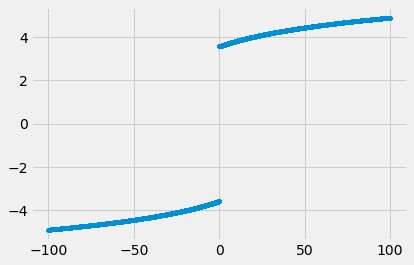

In [5]:
f = lambda x: np.log(np.abs(x)+36.0)*np.sign(x)
x_plot = np.arange(-100, 100, 1e-2)

plt.plot(x_plot, f(x_plot), '.')
plt.draw()

In [6]:
def regularize(x, skip_col=[], abs_val=None):
    
    y = x.copy()
    
    if y.ndim > 1:
        for i in tqdm(range(y.shape[-1]), desc="Preprocessing features"): 
            if skip_col[i]:
                print(f'id({columns[i]})')
                continue
            if abs_val is not None:
                use_abs_val = abs_val[i]
            else:
                channel = y[:,i]
                notnan = channel[~np.isnan(channel)]
                if np.all(notnan>0):
                    use_abs_val = False
                else:
                    use_abs_val = True
            if not use_abs_val:
                print(f'log({columns[i]})')
                y[:,i] = np.log(y[:,i])
            else:
                print(f'log(abs({columns[i]}))*sign')
                zeros = y[:,i]==0
                signs = np.sign(y[:,i])
                y[zeros] = 1 # avoid nan errors
                y[:,i] = np.log(np.abs(y[:,i]))*signs+signs*36.0
                y[zeros] = 0
    else:
        notnan = y[~np.isnan(y)]
        if np.all(notnan>0):
            y = np.log(y)
        else:
            zeros = y==0
            y = np.log(np.abs(y))*np.sign(y)+np.sign(y)*36.0
            y[zeros] = 0
    return y



## Second pre-processing step: Scaling

The second pre-processing step is the same for all predictors, we scale the features so that they have approximately zero-mean and standard deviation of 1: this is usually good for Neural Network training. We do not apply this step to the predictand. We will store the scaler object, as it will be need to pre-process data at inference time.

In [25]:
def prep_samples(dataset, scaler=None, skip_vars=[], abs_val=None, clean_after_reg=False, scale=True):

    print("Dropping empty values...")
    samples = dataset.dropna()
    
    print("Dropping negative EKE samples...")
    # Negative EKE values seem to be more of an artifact than anything else
    samples = samples[samples['EKE']>0]
    
    targets = samples["EKE"]
    print("Removing EKE from features...")
    samples.drop("EKE", inplace=True, axis=1)
    
    skip_col = [columns[i] in skip_vars for i in range(len(samples.columns))]
    
    X = regularize(samples.values, skip_col, abs_val=abs_val)
    
    if clean_after_reg:
        X[~np.isfinite(X)] = 0
    
    Y = np.log(targets.values)
    
    if scale:
        # scale the data
        if scaler is None:
            print("Fitting scaler and scaling data...")
            #scaler = RobustScaler(quantile_range=(25.0, 75.0))
            #scaler = StandardScaler()
            avg = np.float32(np.mean(X, axis=0, dtype=np.float64))
            std = np.float32(np.std(X, axis=0, dtype=np.float64))
            X = (X-avg)/std
            scaler = [avg, std]
        else:
            print("Scaling data with provided scaler...")
            X = (X-scaler[0,:])/scaler[1,:]
    
    X = pd.DataFrame(X, columns=columns)
    
    return X, Y, scaler  
    

Once the data is pre-processed, we split it into train and validation (called test here) sets.

In [26]:
def prep_data(dataset, scaler=None, skip_vars=[]):
    data, targets, scaler = prep_samples(dataset, scaler, skip_vars)
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)
    print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
    print('Dimensions of the training target vector: {}'.format(y_train.shape))
    print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
    print('Dimensions of the test target vector: {}'.format(y_test.shape))
    return X_train, X_test, y_train, y_test, scaler
    

There are two different datasets, one (`cf10`) has values averaged over 10x10 boxes, the other one (`cf2`) is averaged over 2x2 boxes. For each type, we have 120 samples. We only use 110 samples for each type, keeping 10 as test values, which we will use as tests for the trained models.

In [20]:
datapath1 = '/lus/scratch/spartee/MOM-data/MOM6_1-10/'

datapath2 = '/lus/scratch/spartee/MOM6_data/MOM6_1-10_data_with_ssh/'

model_data = ml_eke.pop_data(datapath1, datapath1, skip_vars = ['x','y','depth','depth_stdev'], extra_pref='cf2')
#model_data.extend_inventory(datapath2)
samples = get_samples(0, 11, columns, model_data)
for cf_idx in range(3, 11):
    model_data = ml_eke.pop_data(datapath1, datapath1, skip_vars = ['x','y','depth','depth_stdev'], extra_pref=f'cf{cf_idx}')
 #   model_data.extend_inventory(datapath2)
    scale_factor = cf_idx/2
    samples_loc = get_samples(0, min(int(np.ceil(5*scale_factor*scale_factor)), 110), columns, model_data)
    samples = pd.concat([samples,samples_loc])

# samples_2D, targets_2D, masks_2D = get_samples_2D(0, 111, columns, model_data, predictands=['EKE_sfc'], preprocess=False, skip_preprocess_var=['Rd_dx_z'])
# samples_2D_prep, _, _ = get_samples_2D(0, 111, columns, model_data, predictands=['EKE_sfc'], preprocess=True, skip_preprocess_var=['Rd_dx_z'])

# samples = maps_to_array(samples_2D, targets_2D) 
# samples_prep = maps_to_array(samples_2D_prep, targets_2D) 

# if False:
#     model_data = ml_eke.pop_data(datapath1, datapath1, skip_vars = ['x','y','depth','depth_stdev'], extra_pref='cf3')
#     samples_2D, targets_2D, masks_2D = get_samples_2D(0, 56, columns, model_data, predictands=['EKE_sfc'], preprocess=False, skip_preprocess_var=['Rd_dx_z'])
#     samples_2D_prep, _, _ = get_samples_2D(0, 56, columns, model_data, predictands=['EKE_sfc'], preprocess=True, skip_preprocess_var=['Rd_dx_z'])

#     samples = pd.concat([samples, maps_to_array(samples_2D, targets_2D)])
#     samples_prep = pd.concat([samples_prep, maps_to_array(samples_2D_prep, targets_2D)])

Extracting samples: 100%|██████████| 110/110 [00:01<00:00, 67.22it/s]


In [21]:
# print(samples_2D.shape)

# plt.figure(figsize=(8,24))
# for i in range(samples_2D.shape[-1]):
#     sample = (samples_2D[0, :, :, i])
#     sample_prep = (samples_2D_prep[0, :, :, i])
#     plt.subplot(samples_2D.shape[-1], 1, i+1)
#     plt.pcolormesh(np.log(np.abs(sample-sample_prep)))
#     plt.colorbar()
#     plt.draw()

In [22]:


print(samples.shape)

(63178290, 5)


In [27]:
X_train, X_test, y_train, y_test, scaler = prep_data(samples, skip_vars=['Rd_dx_z'])
#X_train_prep, X_test_prep, y_train_prep, y_test_prep, scaler_prep = prep_data(samples_prep, skip_vars=['Rd_dx_z'])

Dropping empty values...
Dropping negative EKE samples...
Removing EKE from features...


Preprocessing features:   0%|          | 0/4 [00:00<?, ?it/s]

log(MKE_sfc)


Preprocessing features:  25%|██▌       | 1/4 [00:00<00:01,  1.88it/s]

log(slope_z)


Preprocessing features:  50%|█████     | 2/4 [00:01<00:01,  1.88it/s]

id(Rd_dx_z)
log(abs(relative_vorticity_sfc))*sign


Preprocessing features: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Fitting scaler and scaling data...
Dimensions of the training feature matrix: (50542632, 4)
Dimensions of the training target vector: (50542632,)
Dimensions of the test feature matrix: (12635658, 4)
Dimensions of the test target vector: (12635658,)


---------------------------------
min MKE_sfc = -10.551566123962402, max MKE_sfc = 3.7151944637298584
---------------------------------
---------------------------------
min slope_z = -6.642484664916992, max slope_z = 3.058436632156372
---------------------------------
---------------------------------
min Rd_dx_z = -0.6571119427680969, max Rd_dx_z = 9.199753761291504
---------------------------------
---------------------------------
min relative_vorticity_sfc = -1.280612826347351, max relative_vorticity_sfc = 1.3013253211975098
---------------------------------
---------------------------------
min EKE = -12.87537956237793, max EKE = -0.24040384590625763
---------------------------------


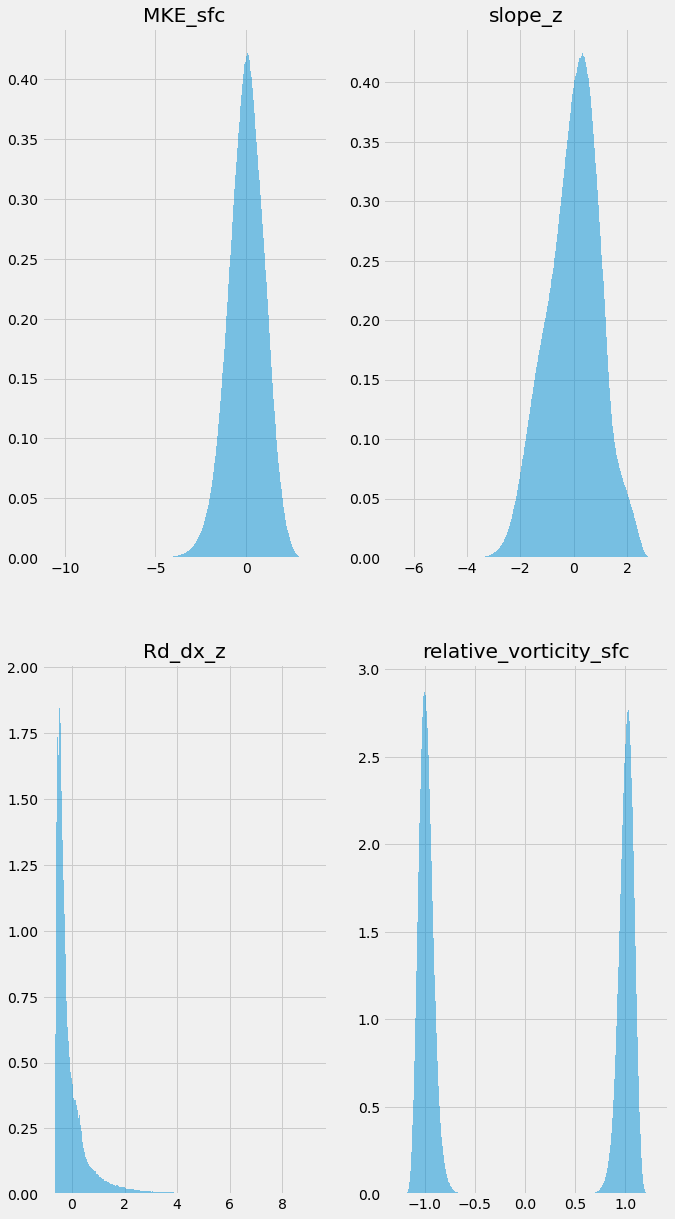

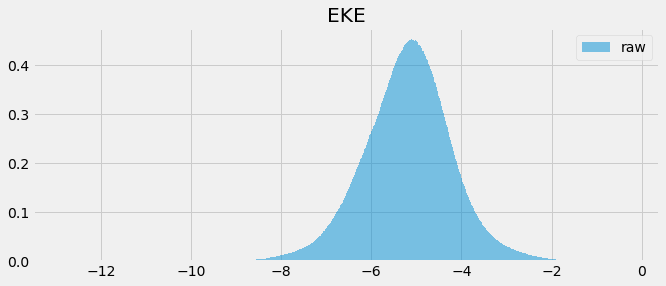

In [28]:
plt.figure(figsize=(10,20))
for i in range(X_train.shape[-1]):
    sample = X_train.values[:, i]
    print('---------------------------------')
    print(f'min {columns[i]} = {np.min(sample)}, max {columns[i]} = {np.max(sample)}')
    print('---------------------------------')
    plt.subplot(len(columns)//2+len(columns)%2,2,i+1)
    plt.hist(sample, bins=1000, density=True, alpha=0.5, label= 'raw')
#     sample_prep = X_train_prep.values[:, i]
#     plt.hist(sample_prep, bins=1000, density=True, alpha=0.5,label= 'preprocessed')
    plt.title(columns[i])
    plt.draw()
    
print('---------------------------------')
print(f'min EKE = {np.min(y_train)}, max EKE = {np.max(y_train)}')
print('---------------------------------')
plt.figure(figsize=(10,4))
plt.hist(y_train, bins=1000, density=True, alpha=0.5)
# plt.hist(y_train_prep, bins=1000, density=True, alpha=0.5)
plt.legend(['raw', 'preprocessed'])
plt.title('EKE')
plt.draw()

## Visual inspection of pre-processing results

Let's have a look at the resulting feature distributions. 

---------------------------------
min Rd_dx_sfc = -0.8726869821548462, max Rd_dx_sfc = 5.372701644897461
---------------------------------
---------------------------------
min grad_SSH_sfc = -3.193877935409546, max grad_SSH_sfc = 4.832203388214111
---------------------------------
---------------------------------
min relative_vorticity_sfc = -1.2189089059829712, max relative_vorticity_sfc = 1.2686271667480469
---------------------------------
---------------------------------
min divergence_sfc = -1.2384390830993652, max divergence_sfc = 1.233933687210083
---------------------------------
---------------------------------
min deformation_sfc = -4.34144926071167, max deformation_sfc = 5.321643352508545
---------------------------------
---------------------------------
min EKE = -10.261910438537598, max EKE = -0.510151207447052
---------------------------------


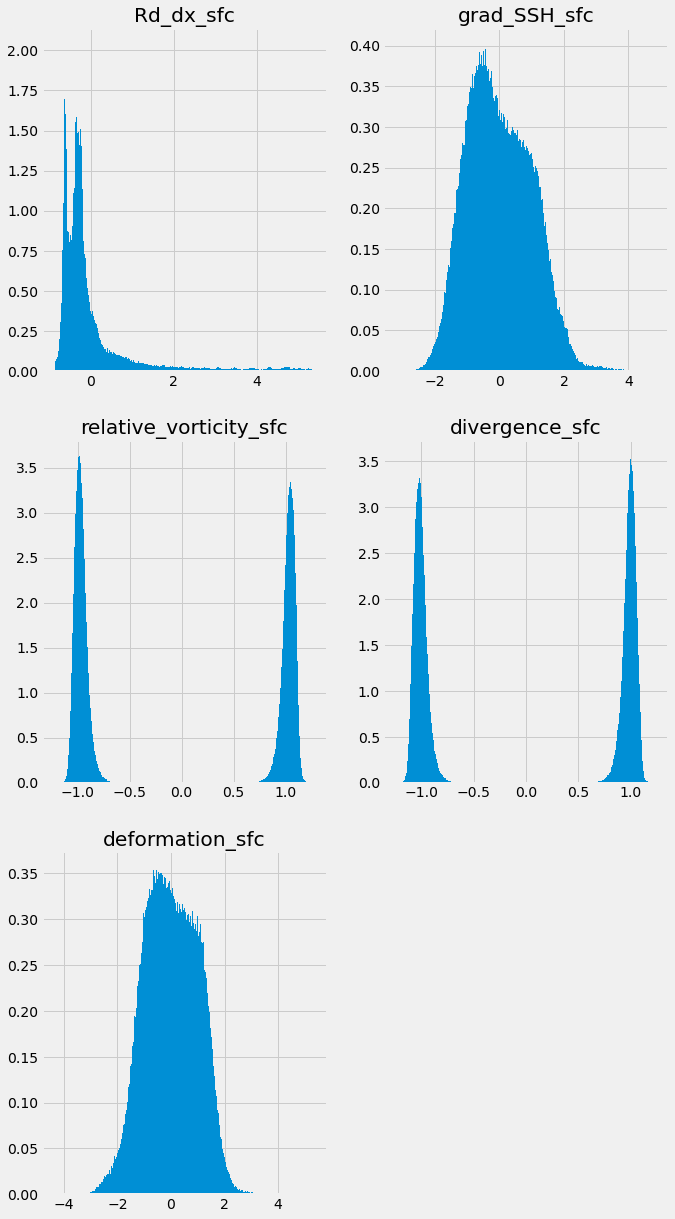

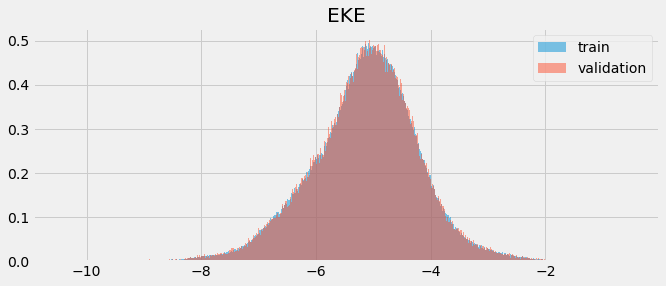

In [219]:
plt.figure(figsize=(10,20))
for i in range(X_train.shape[-1]):
    sample = X_train.values[:, i]
    print('---------------------------------')
    print(f'min {columns[i]} = {np.min(sample)}, max {columns[i]} = {np.max(sample)}')
    print('---------------------------------')
    plt.subplot(len(columns)//2+len(columns)%2,2,i+1)
    plt.hist(sample, bins=1000, density=True)
    plt.title(columns[i])
    plt.draw()
    
print('---------------------------------')
print(f'min EKE = {np.min(y_train)}, max EKE = {np.max(y_train)}')
print('---------------------------------')
plt.figure(figsize=(10,4))
plt.hist(y_train, bins=1000, density=True, alpha=0.5)
plt.hist(y_test, bins=1000, density=True, alpha=0.5)
plt.legend(['train', 'validation'])
plt.title('EKE')
plt.draw()

We notice that the predictand is approximately log-normally distributed. This means that we have way less samples for the values belonging to the two tales, and when we will train the neural network against mean squared error, the extremum values will therefore have less weight. We explored a possible way to mitigate this phenomenon, that is inverse sampling weighting. We approximated the distribution with a Gaussian, and we multiplied the loss function terms by the inverse of the probability density for the predictand values. This custom loss can be found in the `loss.py` file. In the plot below, we see how well the Gaussian distribution fits the train (and validation) sets.

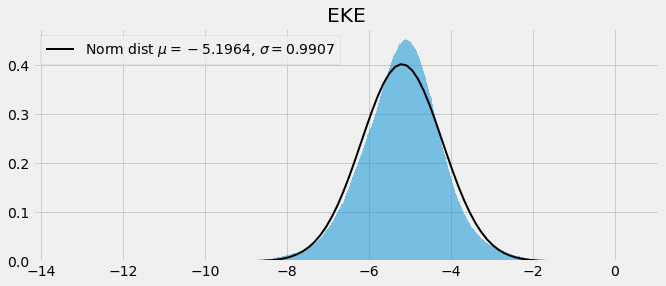

In [25]:
plt.figure(figsize=(10,4))

plt.hist(y_train, bins=1000, density=True, alpha=0.5)
xmin, xmax = plt.xlim()
mu, std = norm.fit(y_train)
x_pdf = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_pdf, mu, std)
plt.plot(x_pdf, p, 'k', linewidth=2)

plt.legend([f'Norm dist $\mu={mu:.4f}$, $\sigma={std:.4f}$'])
plt.title('EKE')
plt.draw()


In [29]:
save = True

if save:
    np.save('ml_eke/nn/data/scaler_cf_all_4_feat', scaler)

#     np.save('ml_eke/nn/data/y_train_cf_all', y_train_prep)
#     np.save('ml_eke/nn/data/y_test_cf_all', y_test_prep)

#     np.save('ml_eke/nn/data/X_train_cf_all', X_train_prep.values)
#     np.save('ml_eke/nn/data/X_test_cf_all', X_test_prep.values)

We will now train an XGBoost regressor, to be able to compare the results of our Neural Network(s) to it. The dataset is too large for the algorithm to run in a reasonable time, thus we will use 1/100th of the data points. 

In [22]:
# If you have the data, just skip the loading and pre-processing

load_data = True
if load_data:
    X_train = pd.DataFrame(np.load('./ml_eke/nn/data/X_train_prep_cf6.npy'), columns=columns)
    X_test =  pd.DataFrame(np.load('./ml_eke/nn/data/X_test_prep_cf6.npy'), columns=columns)

    y_train = np.load('./ml_eke/nn/data/y_train_prep_cf6.npy')
    y_test = np.load('./ml_eke/nn/data/y_test_prep_cf6.npy')

In [23]:
rf = XGBRegressor()
num_samples = X_train.shape[0]
rf.fit(X_train[:num_samples//100], y_train[:num_samples//100]) 
rf.save_model('./ml_eke/nn/data/xgbreg_new')
y_train_rf = rf.predict(X_train[:num_samples//100])
y_test_rf = rf.predict(X_test)
rf_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'training error': [mean_squared_error(y_train[:num_samples//100], y_train_rf)],
            'test error': [mean_squared_error(y_test, y_test_rf)],
            'training_r2_score': [r2_score(y_train[:num_samples//100], y_train_rf)],
            'test_r2_score': [r2_score(y_test, y_test_rf)]})
rf_results

,algorithm,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.360693,0.410061,0.604692,0.54815


The regressor can give us an important insight into the data, we can see what the most relevant features are.

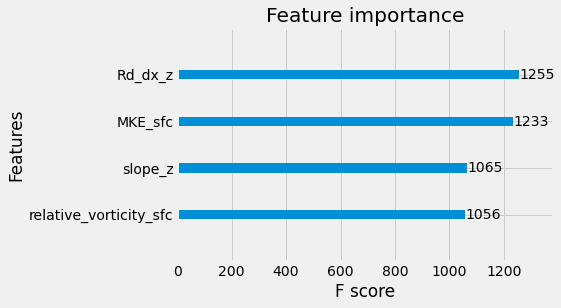

In [24]:
plot_importance(rf)

plt.draw()

We can see that when a feature is available both as surface value (`_sfc`) or averaged along the vertical axis (`_z`), the two features seem to have the same importance. We tried using only one of the two quantities, but the error was slightly larger, thus we defer this to future studies.

# Inference and analysis

In this section, we load two trained neural networks and compare the results with the XGBoost solution. We load the models with `compile=False`, because we do not need to train them. The Neural Network `model_cus` uses the custom loss, whereas `model_mse` uses a standard mean squared error loss. We also load a scaler we previously saved: **notice that this scaler must be the same one used to scale the data we trained our NNs on, otherwise results will be inconsistent**.

In [37]:
import torch
#from nn_models import EKEResnet
from torchsummary import summary

model_mse = torch.load('./ml_eke/nn/pytorch/trained_models/ResNetSmall_4_mse_prep_cf6.pkl', map_location=torch.device('cpu'))
#model_cus = torch.load('./ml_eke/nn/pytorch/trained_models/ResNetSmall_6_custom_prep_cf23.pkl', map_location=torch.device('cpu'))
#print(model_mse)
summary(model_mse, (6,))

#model_mse = keras.models.load_model('ml_eke/nn/trained_models/GEN-INT_l2_0.002_8_2020-12-17_512_mse.h5', compile=False)
#model_cus = keras.models.load_model('ml_eke/nn/trained_models/GEN-INT_l2_0.002_8_2020-12-17_512_custom.h5', compile=False)
#model_mse.summary()

scaler = load(open('ml_eke/nn/data/scaler_prep4_cf6.pkl', 'rb'))
#rf = XGBRegressor()
#rf.load_model('./ml_eke/nn/data/xgbreg_cf10')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1              [-1, 8, 2, 2]             136
       BatchNorm2d-2              [-1, 8, 2, 2]              16
              ReLU-3              [-1, 8, 2, 2]               0
        TransBlock-4              [-1, 8, 2, 2]               0
   ConvTranspose2d-5              [-1, 8, 3, 3]             264
       BatchNorm2d-6              [-1, 8, 3, 3]              16
              ReLU-7              [-1, 8, 3, 3]               0
        TransBlock-8              [-1, 8, 3, 3]               0
   ConvTranspose2d-9              [-1, 8, 4, 4]             264
      BatchNorm2d-10              [-1, 8, 4, 4]              16
             ReLU-11              [-1, 8, 4, 4]               0
       TransBlock-12              [-1, 8, 4, 4]               0
           Conv2d-13              [-1, 4, 4, 4]              32
      BatchNorm2d-14              [-1, 

We load the datasets we did not use to train our NNs and look at how the predicted value distributions compare to the target one.

In [40]:
#datapath1 = '/lus/scratch/spartee/MOM6_1-10/'
#datapath2 = '/lus/scratch/spartee/MOM6_1-10_data_with_ssh/'

datapath_1 = '/lus/scratch/ashao/data/2_3/'
datapath2 = '/lus/scratch/arigazzi/2_3_SSH/'

datapath_1_4 = '/lus/scratch/arigazzi/1_4/'

model_data = ml_eke.pop_data(datapath_1, datapath_1, skip_vars = ['x','y','depth','depth_stdev'], extra_pref=None, first_suffix='_08_001.nc')
#model_data_rough = ml_eke.pop_data(datapath1, datapath1, skip_vars = ['x','y','depth','depth_stdev'], extra_pref='rough', first_suffix='_16_001.nc')


# columns = ['Rd_dx_sfc']
# model_data_1_4 = ml_eke.pop_data(datapath_1_4, datapath_1_4, skip_vars = ['x','y','depth','depth_stdev'], extra_pref=None, first_suffix='_18_001.nc')

# dataset_1_4 = get_samples(1, 200, ['Rd_dx_sfc'], model_data_1_4, predictands=['Rd_dx_sfc'])
# data_1_4, targets_1_4, scaler_1_4 = prep_samples(dataset_1_4)
dataset = get_samples(1, 2, columns, model_data, predictands=['MEKE_z'])
#dataset_rough = get_samples(1, 200, columns, model_data_rough, predictands=['MEKE_sfc'])
data, targets, _ = prep_samples(dataset, scaler=None, abs_val=[True, True, True, True, True, False], clean_after_reg=True, skip_vars=['Rd_dx_z'], scale=True)
#data_norm, _, _  = prep_samples(dataset, scaler=None, abs_val=[True, True, True, True, True, False], clean_after_reg=True, skip_vars=['Rd_dx_z'], scale=False)
#data_rough, targets_rough, _ = prep_samples(dataset_rough, scaler)
data
data_norm = dataset.values[:,0:len(columns)]

Preprocessing features: 100%|██████████| 4/4 [00:00<00:00, 1061.04it/s]

Dropping empty values...
Dropping negative EKE samples...
Removing EKE from features...
log(abs(MKE_sfc))*sign
log(abs(slope_z))*sign
id(Rd_dx_z)
log(abs(relative_vorticity_sfc))*sign
Fitting scaler and scaling data...


We need to whiten inference data. It seems sufficient to get appropriate results.

In [107]:
valid = np.all(~np.isnan(data_norm), axis=1)
data_norm_buf = data_norm.copy()
data_norm = data_norm[valid,:]

print(data_norm.shape)

data_norm[:,[0,1,3,4,5]] = np.log(np.abs(data_norm[:,[0,1,3,4,5]]))*np.sign(data_norm[:,[0,1,3,4,5]])+36.0*np.sign(data_norm[:,[0,1,3,4,5]])

dataset_norm = data_norm.copy()

col_avg = np.mean(dataset_norm, axis=0, dtype=np.float64)
col_std = np.std (dataset_norm, axis=0, dtype=np.float64)

print(col_avg)
print(col_std)

dataset_norm = (dataset_norm-col_avg)/col_std

print(np.mean(dataset_norm, axis=0, dtype=np.float64))
print(np.std (dataset_norm, axis=0, dtype=np.float64))

data_norm = data_norm_buf

(188143356, 6)
[30.2260008  30.43432105  1.04536663 -0.06344519  0.03875982 21.6490382 ]
[ 1.76713417  2.0337035   1.15321282 21.2609123  20.95582088  1.07971928]
[-4.37503679e-15 -1.49492891e-15  6.35446470e-14  1.52943452e-16
  9.96898638e-17 -4.22172072e-16]
[1. 1. 1. 1. 1. 1.]


In [109]:
# torchscript
model_mse.eval()
class InferenceCell(torch.nn.Module):
    def __init__(self):
        super(InferenceCell, self).__init__()
        self.model = model_mse

        self.avg = torch.tensor([30.2260008,  30.43432105,  1.04536663, -0.06344519,  0.03875982, 21.6490382 ])
        self.sd = torch.tensor([ 1.76713417,  2.0337035,   1.15321282, 21.2609123,  20.95582088,  1.07971928])
        
        
    def forward(self, x):
        x[[0,1,3,4,5]] = torch.log(torch.abs(x[[0,1,3,4,5]]))*torch.sign(x[[0,1,3,4,5]])+36.0*torch.sign(x[[0,1,3,4,5]])
        
        x = (x - self.avg) / self.sd
        x = self.model(x)
        return x

inference_cell = InferenceCell()
x = torch.tensor(data_norm[0,:].copy())
print(f'{x} out')
traced_cell = torch.jit.trace(inference_cell, (x))
#print(traced_cell.graph)
x = torch.tensor(data_norm[0,:].copy())
print(f'{x} out')
print("return: ", traced_cell(x))
traced_cell.save('./ml_eke/nn/pytorch/trained_models/resnet_small_6_feats_cf23_norm1_4.pt')

tensor([ 1.3088e-03,  1.3278e-01,  1.5215e-01, -1.6949e-06,  3.9071e-07,
         2.9142e-06]) out
tensor([ 1.3088e-03,  1.3278e-01,  1.5215e-01, -1.6949e-06,  3.9071e-07,
         2.9142e-06]) out
return:  tensor([[-5.5941]], grad_fn=<AddBackward0>)


---------------------------------
0: min MKE_sfc = -11.749771118164062, max MKE_sfc = 3.6043219566345215
---------------------------------
---------------------------------
1: min slope_z = -5.0279436111450195, max slope_z = 3.207948923110962
---------------------------------
---------------------------------
2: min Rd_dx_z = -0.8920354843139648, max Rd_dx_z = 3.262106418609619
---------------------------------
---------------------------------
3: min relative_vorticity_sfc = -1.2705937623977661, max relative_vorticity_sfc = 1.2922635078430176
---------------------------------
---------------------------------
4: min divergence_sfc = -1.2674612998962402, max divergence_sfc = 1.2913604974746704
---------------------------------
---------------------------------
5: min deformation_sfc = -9.970641136169434, max deformation_sfc = 6.625070571899414
---------------------------------
---------------------------------
min EKE = -17.09273910522461, max EKE = 0.14726194739341736
----------------

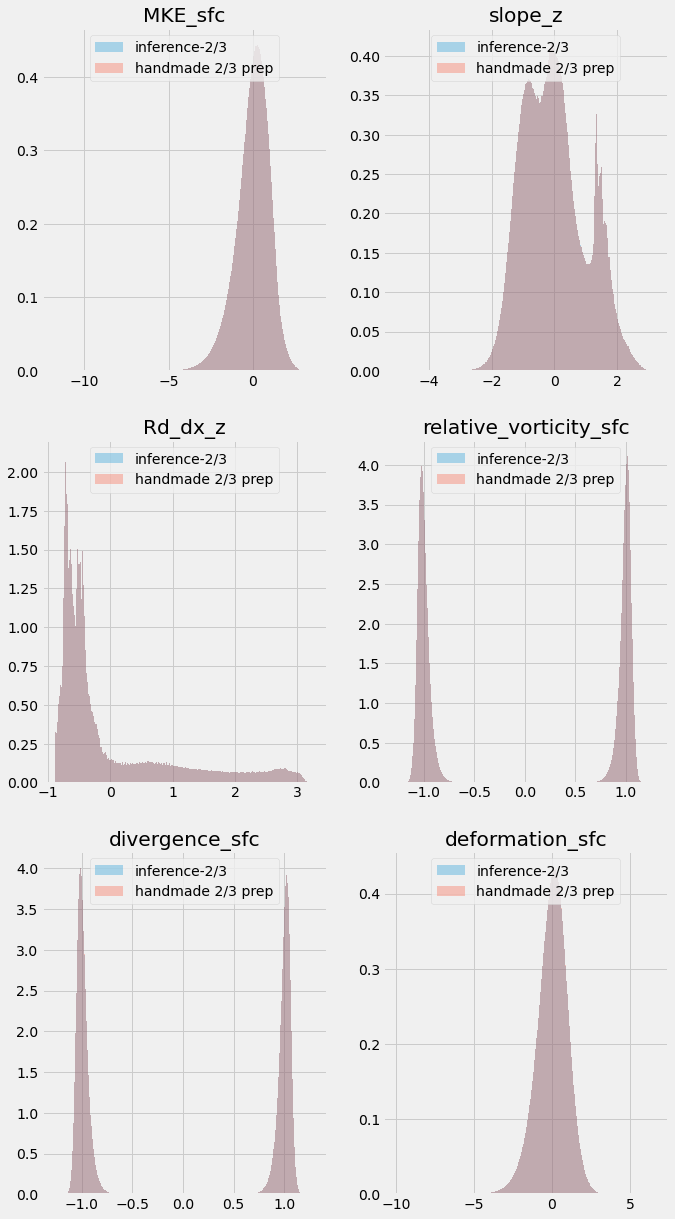

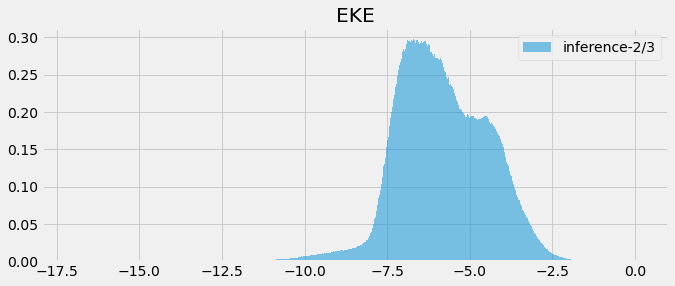

In [55]:
plt.figure(figsize=(10,20))
xlims = [[-3,3],[-3,3],[0.6,1.2],[0.6,1.2],[-3,3],[-3,3]]
for i in range(data.shape[-1]):
    sample = data.values[:, i]
    print('---------------------------------')
    print(f'{i}: min {columns[i]} = {np.min(sample)}, max {columns[i]} = {np.max(sample)}')
    print('---------------------------------')
    plt.subplot(len(columns)//2+len(columns)%2,2,i+1)
    plt.hist(sample, bins=1000, density=True, alpha=0.3, label='inference-2/3')
#     sample = data_rough.values[:, i]
#     plt.hist(sample, bins=1000, density=True, alpha=0.3, label='inference-2/3 rough')
    #sample = X_train.values[:, i]
    #plt.hist(sample, bins=1000, density=True, alpha=0.3, label='training-1/10-cf6-raw')
    #sample = X_train_prep.values[:, i]
    #plt.hist(sample, bins=1000, density=True, alpha=0.3, label='training-1/10-cf6-prep')
    sample = dataset_norm[:,i]
    plt.hist(sample, bins=1000, density=True, alpha=0.3, label='handmade 2/3 prep')
    #plt.xlim(xlims[i])
    plt.legend(loc='upper center')
    plt.title(columns[i])
    plt.draw()

plt.savefig('feature_dist.png')

print('---------------------------------')
print(f'min EKE = {np.min(targets)}, max EKE = {np.max(targets)}')
print('---------------------------------')
plt.figure(figsize=(10,4))
plt.hist(targets, bins=1000, density=True, alpha=0.5, label='inference-2/3')
# plt.hist(targets_rough, bins=1000, density=True, alpha=0.5, label='inference-2/3 rough')
#plt.hist(y_train_prep, bins=1000, density=True, alpha=0.5, label='training-1/10-cf6')
plt.legend(loc='upper center')
plt.legend()
plt.title('EKE')
plt.draw()

[-1.2712495  -0.13898323 -0.7532198   1.0108413  -1.0322123   0.22503655]
[-1.27124952 -0.13898324 -0.75321974  1.01084124 -1.03221226  0.22503655]
[ 6.9776387e-04  1.0452730e-03  1.1044711e-01  3.8541552e-07
 -5.2418295e-07  5.8052058e-07]
[-1.27124952 -0.13898324 -0.75321974  1.01084124 -1.03221226  0.22503655]
[[-5.4708714]]


NameError: name 'y_test_prep' is not defined

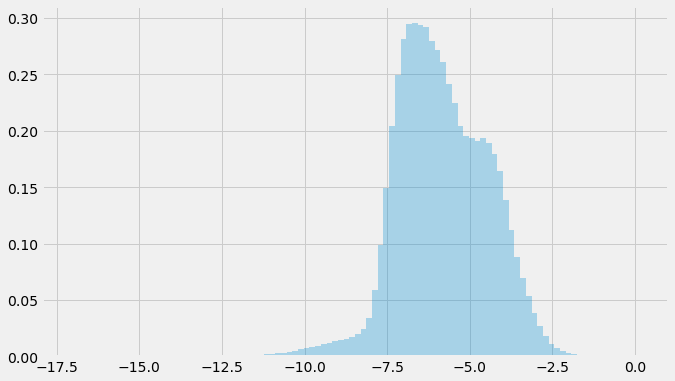

In [84]:
# make some predictions
#preds_cus = model_cus(torch.tensor(data_10.values))
#preds_cus = preds_cus.detach().numpy()
print(data.values[0,:])
print(dataset_norm[0,:])
print(data_norm[0,:])
data_sample = data_norm[0,:].copy()
data_sample[[0,1,3,4,5]] = np.log(np.abs(data_sample[[0,1,3,4,5]]))*np.sign(data_sample[[0,1,3,4,5]])+36.0*np.sign(data_sample[[0,1,3,4,5]])
print((data_sample-col_avg)/col_std)

preds_mse = model_mse(torch.tensor(data.values[0,:]))
preds_mse = preds_mse.detach().numpy()
#preds_rf  = rf.predict(data_10).reshape((-1,1))
print(preds_mse)

# show true distribution vs predicted
plt.figure(figsize=(10,6))
plt.hist(targets,bins=100,alpha=0.3,label='MEKE distribution', density=True)
plt.hist(y_test_prep, bins=100, density=True, alpha=0.5, label='Training-1/10-cf6')
#plt.hist(preds_cus,bins=100,alpha=0.3,label='Predicted Custom', density=True)
plt.hist(preds_mse,bins=100,alpha=0.3,label='Predicted MSE', density=True)
#plt.hist(preds_rf,bins=100,alpha=0.3,label='Predicted XGB', density=True, color='green')
plt.legend()
plt.draw()

plt.savefig('EKE_dist.png')

With the newest data, it seems like XGB and the MSE model are pretty similar in outcome, whereas the custom loss performs better on the tails of the distribution, but poorly on the peak.

To display the results in a meaningful way, we keep the original samples as maps, instead of collecting single point values. 

In [12]:
def prep_maps(sample, target, mask, scaler, model, abs_val=None, clean_after_reg=True, skip_vars=None):
    sample_shape = sample.shape
    target_shape = target.shape
    
    X = sample.reshape(-1,sample_shape[-1])
    Y = target.reshape(-1,1)
    mask_flat = mask.reshape(-1,1)
    
    samples = pd.DataFrame(X, columns=columns)
    targets = pd.DataFrame(Y, columns=["EKE"])

    samples["EKE"] = targets["EKE"]
    
    data_out, targets_out, _ = prep_samples(samples, scaler, abs_val=abs_val, clean_after_reg=clean_after_reg, skip_vars=skip_vars)
    
    if isinstance(model, XGBRegressor):
        pred = model.predict(data_out)
    else:
        pred = model(torch.tensor(data_out.values))
        pred = pred.detach().numpy()
        
    
    data_map = np.zeros(sample_shape)
    for channel in range(sample_shape[-1]):
        map_channel = data_map[:,:,:,channel:channel+1]
        map_channel[mask] = data_out.values[:,channel:channel+1]
        map_channel[~mask] = np.nan
        
    targets_map = np.zeros(target_shape)
    targets_map[mask,0] = targets_out
    targets_map[~mask,0] = np.nan
    
    pred_map = np.zeros(target_shape)
    pred_map[mask,0] = pred.squeeze()
    pred_map[~mask,0] = np.nan
    
    
    return data_map, targets_map.squeeze(), pred_map.squeeze()
    

In [41]:
# datapath1 = '/lus/scratch/spartee/MOM6_1-10/'

# datapath2 = '/lus/scratch/spartee/MOM6_1-10_data_with_ssh/'

# datapath1 = '/lus/scratch/arigazzi/2_3_MOM6_data/'
# datapath2 = '/lus/scratch/arigazzi/2_3_SSH/'

# datapath1 = '/lus/scratch/ashao/data/2_3_rough/'

# model_data = ml_eke.pop_data(datapath1, datapath1, skip_vars = ['x','y','depth','depth_stdev'], extra_pref=None)
# model_data.extend_inventory(datapath2)


#del sample_10, target_10, mask_10, disp_sample_10, disp_target_10, disp_pred_10_mse

sample, target, mask = get_samples_2D(120, 121, columns, model_data, predictands=['MEKE_z'])
disp_sample, disp_target, disp_pred_mse = prep_maps(sample, target, mask, scaler=scaler, model=model_mse, abs_val=[True, True, True, True, True, False], clean_after_reg=True, skip_vars=['Rd_dx_z'])

# sample_rough, target_rough, mask_rough = get_samples_2D(110, 111, columns, model_data_rough, predictands=['MEKE_sfc'])
# disp_sample_rough, disp_target_rough, disp_pred_rough_mse = prep_maps(sample_rough, target_rough, mask_rough, scaler, model_mse)

Extracting 2D samples: 0it [00:00, ?it/s]
Preprocessing features: 100%|██████████| 4/4 [00:00<00:00, 963.43it/s]


Dropping empty values...
Dropping negative EKE samples...
Removing EKE from features...
log(abs(MKE_sfc))*sign
log(abs(slope_z))*sign
id(Rd_dx_z)
log(abs(relative_vorticity_sfc))*sign
Scaling data with provided scaler...


We start by plotting the predicted values for the two different NNs. We can see that they perform better on the high-resolution dataset, less on the coarser one. Two possible reasons are: the ratio between the number of fine- and coarse-grained samples is ~25:1, this means that the network will be trained mostly on high-resolution samples; the information (and thus the prediction) might be more accurate when less averaging takes place.

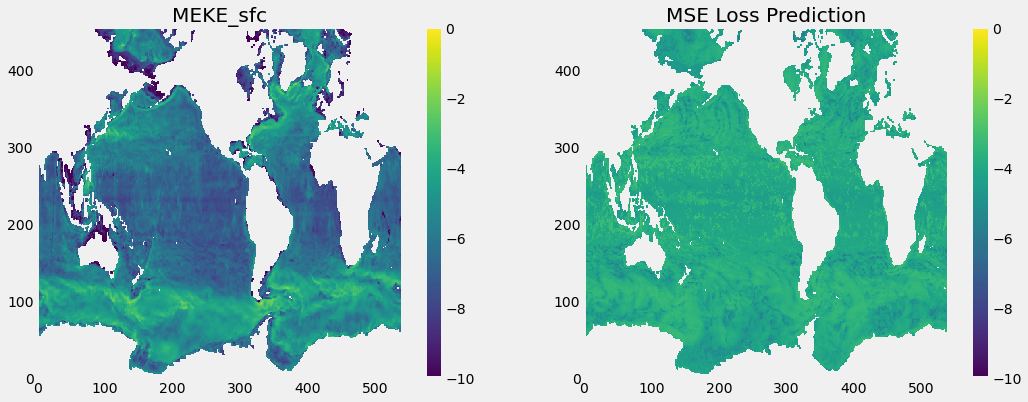

In [43]:
#mask_2_s  = mask_2.squeeze()
mask_s = mask.squeeze()
# mask_rough_s = mask_rough.squeeze()

plt.figure(figsize=(16,6))

vmin = -10
# vmin = min(np.min(disp_target[mask_s]),
# np.min(disp_pred_mse[mask_s]))
# np.min(disp_pred_rough_mse[mask_rough_s]))
vmax = 0
# vmax = max(np.max(disp_target[mask_s]),
# np.max(disp_pred_mse[mask_s]))
# vmax=max(vmax, np.max(disp_pred_rough_mse[mask_rough_s])))

plt.subplot(1,2,1)
plt.pcolormesh(disp_target, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('MEKE_sfc')
plt.subplot(1,2,2)
plt.pcolormesh(disp_pred_mse, vmin=vmin, vmax=vmax)
plt.title('MSE Loss Prediction')
plt.colorbar()

# plt.subplot(1,3,3)
# plt.pcolormesh(disp_pred_rough_mse, vmin=vmin, vmax=vmax)
# plt.title('MSE Prediction Rough')
# plt.colorbar()
#plt.pcolormesh(disp_pred_10_cus, vmin=vmin, vmax=vmax)
#plt.title('Custom loss Prediction')

# vmin = min(np.min(disp_target_2[mask_2_s]),
#            np.min(disp_pred_2_mse[mask_2_s]),
#            np.min(disp_pred_2_cus[mask_2_s]))
# vmax = max(np.max(disp_target_2[mask_2_s]),
#            np.max(disp_pred_2_mse[mask_2_s]),
#            np.max(disp_pred_2_cus[mask_2_s]))
# plt.subplot(2,3,4)
# plt.pcolormesh(disp_target_2, vmin=vmin, vmax=vmax)
# plt.title('Target 2x2')
# plt.subplot(2,3,5)
# plt.pcolormesh(disp_pred_2_mse, vmin=vmin, vmax=vmax)
# plt.title('MSE Prediction')
# plt.subplot(2,3,6)
# plt.pcolormesh(disp_pred_2_cus, vmin=vmin, vmax=vmax)
# plt.title('Custom loss Prediction')
# plt.draw()

plt.savefig('predicted_ML.png')


In [49]:
samples_23, targets_23, mask_23 = get_samples_2D(0, 1, columns, model_data, predictands=['MEKE_z'], preprocess=False, skip_preprocess_var=['Rd_dx_z'])
print(samples_23.shape)

Extracting 2D samples: 0it [00:00, ?it/s]

(1, 455, 540, 4)


(-18.982742, -0.29734275)
(-14.373012, -0.17347685)


/lus/scratch/arigazzi/anaconda3/envs/ncar_torch/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/lus/scratch/arigazzi/anaconda3/envs/ncar_torch/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in log

/lus/scratch/arigazzi/anaconda3/envs/ncar_torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

divide by zero encountered in log



(-12.785789, 1.3472846)
(-26.778582, -8.874514)


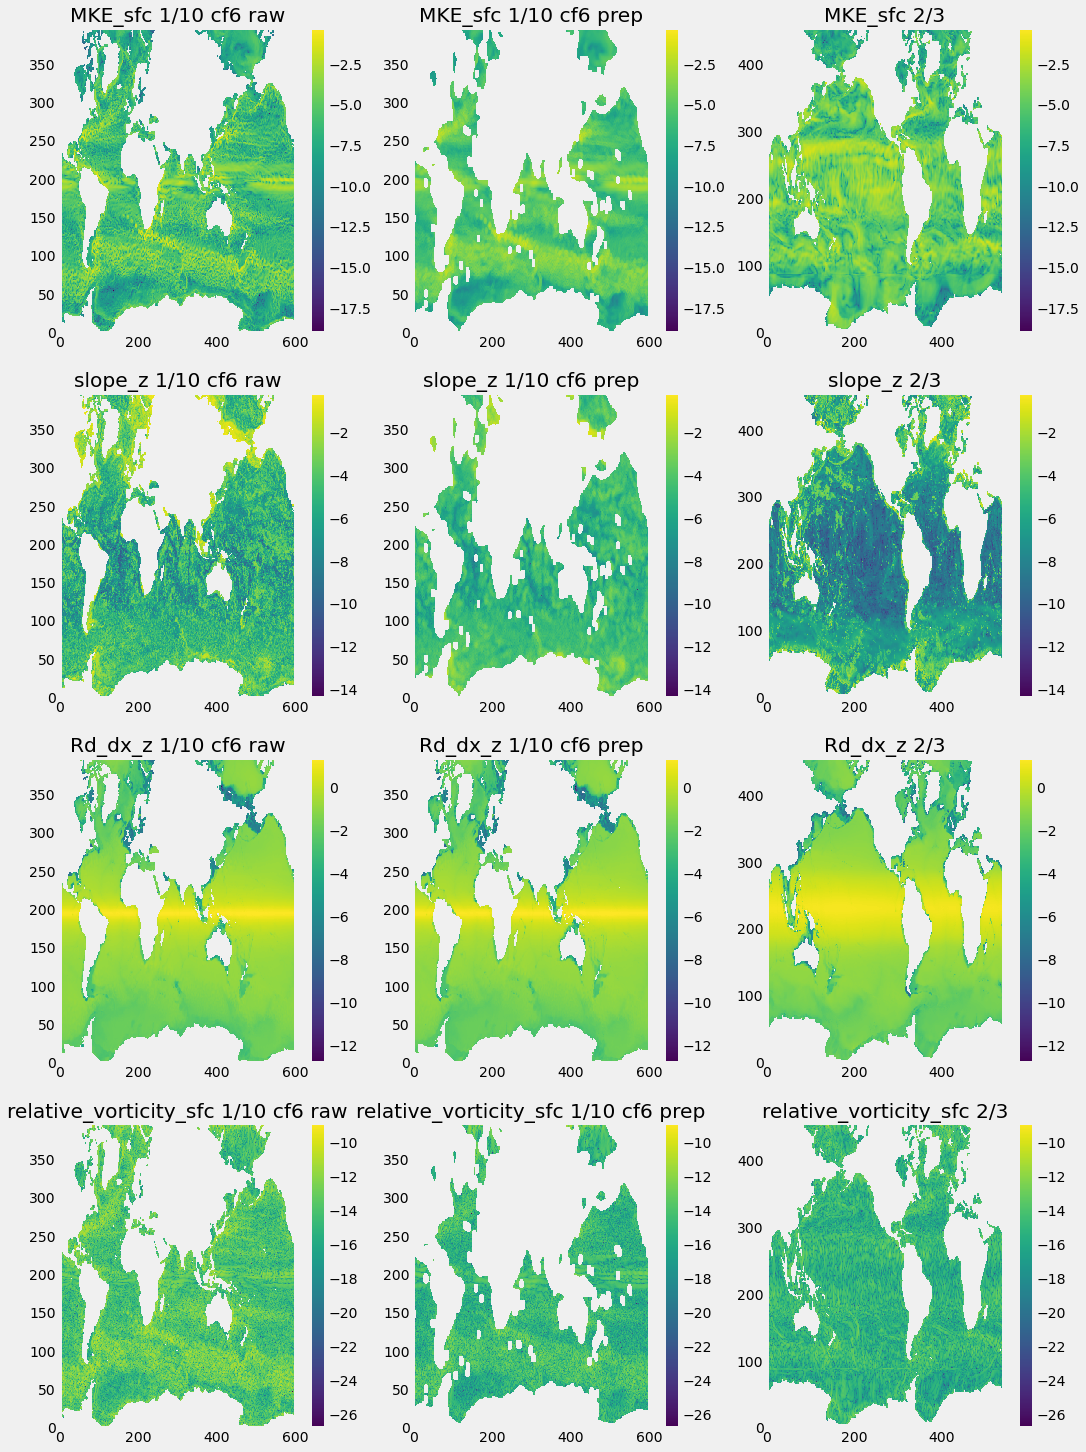

In [45]:
plt.figure(figsize=(16,24))
for i in range(samples_2D.shape[-1]):
    sample = np.log(np.abs(samples_2D[0, :, :, i]))
    sample_prep = np.log(np.abs(samples_2D_prep[0, :, :, i]))
    sample_23 = np.log(np.abs(samples_23[0,:,:,i]))
    
    vmin = min(np.min(sample[masks_2D[0]]), np.min(sample_prep[masks_2D[0]]), np.min(sample_23[mask_23.squeeze()]))
    vmax = max(np.max(sample[masks_2D[0]]), np.max(sample_prep[masks_2D[0]]), np.max(sample_23[mask_23.squeeze()]))
    
    print((vmin, vmax))
    
    plt.subplot(samples_2D.shape[-1], 3, 3*i+1)
    plt.pcolormesh(sample, vmin=vmin, vmax=vmax)
    plt.title(f'{columns[i]} 1/10 cf6 raw')
    plt.colorbar()
    plt.subplot(samples_2D.shape[-1], 3, 3*i+2)
    plt.pcolormesh(sample_prep, vmin=vmin, vmax=vmax)
    plt.title(f'{columns[i]} 1/10 cf6 prep')
    plt.colorbar()
    plt.subplot(samples_2D.shape[-1], 3, 3*i+3)
    plt.title(f'{columns[i]} 2/3')
    plt.pcolormesh(sample_23, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.draw()
    
plt.savefig('features.png')

We plot the error for the three models (MSE, custom loss, and XGBoost). We see again that MSE and XGBoost are almost indistinguishable. 

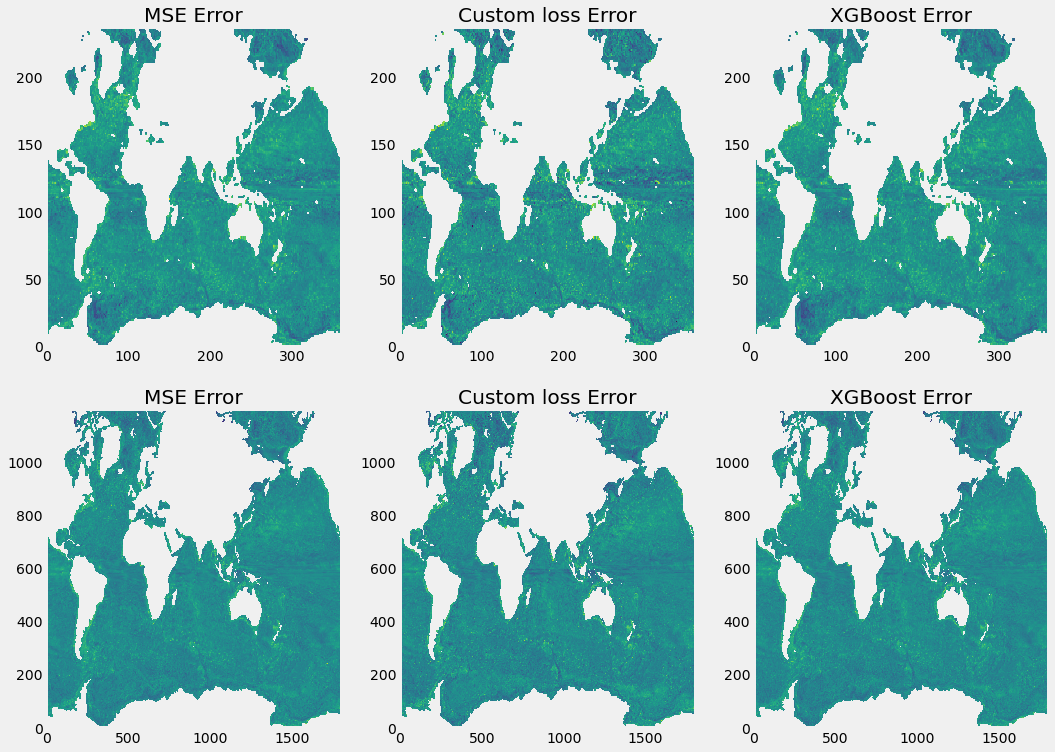

In [14]:
plt.figure(figsize=(16,12))

disp_err_10_mse = disp_target_10 - disp_pred_10_mse
disp_err_10_cus = disp_target_10 - disp_pred_10_cus
disp_err_10_rf = disp_target_10 - disp_pred_10_rf

disp_err_2_mse = disp_target_2 - disp_pred_2_mse
disp_err_2_cus = disp_target_2 - disp_pred_2_cus
disp_err_2_rf = disp_target_2 - disp_pred_2_rf

vmin = min(np.min(disp_err_10_mse[mask_10_s]),
           np.min(disp_err_10_cus[mask_10_s]),
           np.min(disp_err_10_rf[mask_10_s]))
vmax = max(np.max(disp_err_10_mse[mask_10_s]),
           np.max(disp_err_10_cus[mask_10_s]),
           np.max(disp_err_10_rf[mask_10_s]))
plt.subplot(2,3,1)
plt.pcolormesh(disp_err_10_mse, vmin=vmin, vmax=vmax)
plt.title('MSE Error')
plt.subplot(2,3,2)
plt.pcolormesh(disp_err_10_cus, vmin=vmin, vmax=vmax)
plt.title('Custom loss Error')
plt.subplot(2,3,3)
plt.pcolormesh(disp_err_10_rf, vmin=vmin, vmax=vmax)
plt.title('XGBoost Error')

vmin = min(np.min(disp_err_2_mse[mask_2_s]),
           np.min(disp_err_2_cus[mask_2_s]),
           np.min(disp_err_2_rf[mask_2_s]))
vmax = max(np.max(disp_err_2_mse[mask_2_s]),
           np.max(disp_err_2_cus[mask_2_s]),
           np.max(disp_err_2_rf[mask_2_s]))
plt.subplot(2,3,4)
plt.pcolormesh(disp_err_2_mse, vmin=vmin, vmax=vmax)
plt.title('MSE Error')
plt.subplot(2,3,5)
plt.pcolormesh(disp_err_2_cus, vmin=vmin, vmax=vmax)
plt.title('Custom loss Error')
plt.subplot(2,3,6)
plt.pcolormesh(disp_err_2_rf, vmin=vmin, vmax=vmax)
plt.title('XGBoost Error')
plt.draw()

In [15]:
disp_err_10_mse_hist = disp_err_10_mse[mask_10_s].copy().reshape((-1,1))
disp_err_10_cus_hist = disp_err_10_cus[mask_10_s].copy().reshape((-1,1))
disp_err_10_rf_hist  = disp_err_10_rf[mask_10_s].copy().reshape((-1,1))
disp_err_2_mse_hist = disp_err_2_mse[mask_2_s].copy().reshape((-1,1))
disp_err_2_cus_hist = disp_err_2_cus[mask_2_s].copy().reshape((-1,1))
disp_err_2_rf_hist = disp_err_2_rf[mask_2_s].copy().reshape((-1,1))

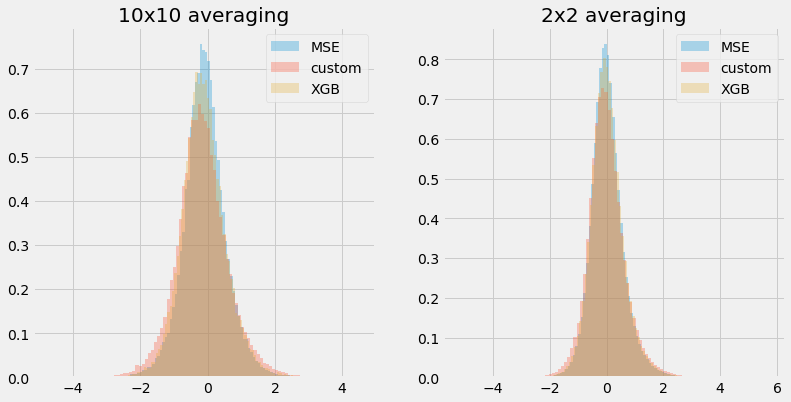

In [16]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(disp_err_10_mse[mask_10_s].reshape((-1,1)), bins=100, density=True, label='MSE', alpha=0.3)
plt.hist(disp_err_10_cus[mask_10_s].reshape((-1,1)), bins=100, density=True, label='custom', alpha=0.3)
plt.hist(disp_err_10_rf[mask_10_s].reshape((-1,1)), bins=100, density=True, label='XGB', alpha=0.3)
plt.title('10x10 averaging')
plt.legend()

plt.subplot(1,2,2)
plt.hist(disp_err_2_mse[mask_2_s].reshape((-1,1)), bins=100, density=True, label='MSE', alpha=0.3)
plt.hist(disp_err_2_cus[mask_2_s].reshape((-1,1)), bins=100, density=True, label='custom', alpha=0.3)
plt.hist(disp_err_2_rf[mask_2_s].reshape((-1,1)), bins=100, density=True, label='XGB', alpha=0.3)
plt.title('2x2 averaging')
plt.legend()
plt.draw()

We see that in terms of error, MSE achieves the best distribution, a narrower peak around 0 and, as expected, the 2x2 averaged data is predicted more accurately.

As a historical remark, we note that the CNN was adapted from the one we used with a previous version of the data, which did not have the `Rd_dx_z` feature and predictions were less accurate. With this new feature, it is possible that a slimmer model would be as efficient as the CNN, and require less computation power.